In [701]:
# 12 - LONG READS
#
# This script takes the information in tagged_reads.csv and combines the reads into long reads. The script is based on 12_long_reads.ipynb
#
# INPUTS:
#   run_number
#   disease
#   tagged_reads.csv
# 
# OUTPUTS:
#   tagged_long_reads.csv

# Load modules

In [877]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Set variables

In [703]:
run_number="run1"
chrom="chr11"
dis="sca"

# Setup
chrom_dis=f"{chrom}_{dis}"
rootdir=f"/mnt/aretian/genomics/nanopore"
datadir=f"/mnt/aretian/genomics/nanopore/{run_number}"

# Parameters
expected_gap_fraction = 0.5

In [704]:
print('')
print('----------------------------------------------------------------------')
# print(f'12 - CREATE LONG READS (__file__})')
print(f'12 - CREATE LONG READS)')
print(f"Run: {run}, disease: {dis}.")
print('')
print('')


----------------------------------------------------------------------
12 - CREATE LONG READS)
Run: 1, disease: sca.




# Load Data

In [705]:
df = pd.read_csv(f'{datadir}/{run_number}_{chrom}_tagged_reads.csv')
df = df.rename(columns={'startpos':'orig_pos'})
shift = min(df['orig_pos'])
df['pos'] = df['orig_pos'] - shift
df['seq_len']= df['read'].apply(lambda x: len(x))
df['end_pos']=df['pos']+df['seq_len']-1
df['sample'] = df['samplename'].str[-1].astype(int)

# Descriptive Statistics

In [726]:
total_length = max(df['end_pos'])
reads_0 = df[df['sample']==0]
reads_1 = df[df['sample']==1]

# Number of reads
n_0=len(reads_0)
n_1=len(reads_1)

# Average length
mean_length = df['seq_len'].mean()
mean_length_0 = reads_0['seq_len'].mean()
mean_length_1 = reads_1['seq_len'].mean()

# Total bins
expected_gap = mean_length*expected_gap_fraction
bin_length = round(mean_length + expected_gap)
n_bins_exact = total_length/bin_length 
n_bins = round(n_bins_exact)

# Bins in  person0
n_long_reads_0 = n_0/n_bins
# Bins in person1
n_long_reads_1 = n_1/n_bins

print(f"Total length of region:     {total_length:,.0f}")
print(f"Avg read length:               {mean_length:,.2f}")
print(f"Avg read length + {expected_gap_fraction*100:,.0f}% padd:    {mean_length+expected_gap:,.2f}")
print(f"Bin length:                    {bin_length:,.0f}")
print(f"total_length/bin_length:           {n_bins_exact:,.2f}")
print(f"Number of bins:                    {n_bins:,.2f} --> last bin is {'shorter' if (n_bins>n_bins_exact) else 'longer'}.")
print("")
print(f"               Count       Avg Length    N of long reads ")
print(f"person0        {n_0:,.0f}       {mean_length:,.0f}        {n_long_reads_0:,.0f}")   
print(f"person1        {n_1:,.0f}       {mean_length_0:,.0f}        {n_long_reads_1:,.0f}")
print(f"Full sample    {len(df):,.0f}       {mean_length_1:,.0f}        {n_long_reads_0 + n_long_reads_1:,.0f}")

Total length of region:     4,080,268
Avg read length:               37,296.16
Avg read length + 50% padd:    55,944.25
Bin length:                    55,944
total_length/bin_length:           72.93
Number of bins:                    73.00 --> last bin is shorter.

               Count       Avg Length    N of long reads 
person0        4,494       37,296        62
person1        1,548       36,921        21
Full sample    6,042       38,386        83


# Create bins

In [727]:
# How to calculate optimal number of bins
# Calculate average read length: 15000
# Include reasonable gaps: 15000
# How many reads per long_read? 4M/30K= 133 bins (reads per long_read)
# How many reads do I have? 1100
# What is the depth? 1100/133 = 8.3

In [728]:
# Create bins
bins = []

last_bin_end = 0
for i in range(int(np.floor(n_bins))):
    bin_start = last_bin_end + 1
    bin_end   = bin_start + bin_length - 1
    bins.append([bin_start, bin_end])
    last_bin_end = bin_end

# Calculate and repor tlast bin length    

# Gap
bin_agg_length = n_bins * bin_length
gap = total_length - bin_agg_length
print(f"Total length:         {total_length:,.0f}")
print(f"Bin aggregate length: {bin_agg_length:,.0f}")
print(f"Difference:              {gap:,.0f}")

# Last bin length
last_bin_length = bin_length + gap
print(f"Bin length:              {bin_length:,.0f}")
print(f"Last bin length:         {last_bin_length:,.0f}")

# Adjust last bin length
bins[-1][1]=bins[-1][0]+last_bin_length-1

Total length:         4,080,268
Bin aggregate length: 4,083,912
Difference:              -3,644
Bin length:              55,944
Last bin length:         52,300


# Assign reads to bins

In [729]:
# Select person
selected_person = 1
print(f"Selected person: person{selected_person}")

if   selected_person == 0:
    person_reads = reads_0.copy()
elif selected_person == 1:
    person_reads = reads_1.copy()

# Count empty bins
empty_bins = 0

# Initialize bin column with empty lists
person_reads['bin']=np.empty((len(person_reads), 0)).tolist()

# Lambda function to append bin membership to list
def append_bin(read, bin):
    read['bin'].append(bin)
    return read

# Add bin membership column to person_reads df

for n, bin in enumerate(bins):

    # Get reads in bin
    read_starts_inside = (person_reads['pos']    >bin[0]) & (person_reads['pos']    <bin[1])
    read_ends_inside   = (person_reads['end_pos']>bin[0]) & (person_reads['end_pos']<bin[1])
    read_covers        = (person_reads['pos']    <bin[0]) & (person_reads['end_pos']>bin[1])
    
    overlaps_bin = (read_starts_inside | read_ends_inside | read_covers)
    
    # Count empty bins
    if overlaps_bin.sum() == 0:
        empty_bins = empty_bins + 1
        print(f'Empty bin: {n}')
        continue
    
    # Append bin number to bin column
    person_reads.loc[overlaps_bin].apply(lambda x: append_bin(x, n), axis=1)

print(f"Reads with no assigned bin: {person_reads['bin'].isna().sum()}")
print(f"Empty bins: {empty_bins}")

Selected person: person1
Empty bin: 6
Empty bin: 10
Empty bin: 25
Empty bin: 26
Empty bin: 46
Empty bin: 47
Empty bin: 48
Empty bin: 54
Empty bin: 67
Reads with no assigned bin: 0
Empty bins: 9


# Draw reads into each bin 

In [730]:
# Plot distribution of reads over the 4M range
# ----  ----  ----     -   -----   ---    -----
#     ----  -- ----    -----   ---    -----
# --  ---  ----   -----   ---    - ---- -----
# 62*71

In [743]:
# Initialize long read membership
person_reads['long_read'] = np.nan
# Track reads that are already assigned
person_reads['assigned'] = False

long_read_number = 0

while person_reads['assigned'].sum() < len(person_reads):
    # While there are unassigned reads

    n_unassigned = len(person_reads) - person_reads['assigned'].sum()
    progress = (1-n_unassigned/len(person_reads))*100
    
    for n, bin in enumerate(bins):
    # Run bin loop assigning reads
        print(f"\rLong read: {long_read_number:3.0f}. Bin: {n:3.0f}. Unassigned: {n_unassigned:5.0f}. Progress: {progress:3.0f}%", end="", flush=True)
#         print(f"Bin number: {n}")
    
        # Get reads in bin
        bin_reads_boolean = person_reads.apply(lambda x: n in x['bin'], axis=1)
        
        # Get reads in bin that are not assigned
        bin_reads = person_reads.loc[bin_reads_boolean & ~person_reads['assigned']]
        
        # Get first read, assign it to long read
        try:
            selected_index = bin_reads.index[0]
        except: # The bin is empty
#             print(f'Empty bin: {n}')
            continue
        
        person_reads.loc[selected_index, 'long_read'] = long_read_number
#         bin_reads.loc[0, 'long_read'] = long_read_number
        
        # Record assignment
        person_reads.loc[selected_index, 'assigned'] = True
        
        # Add check of already assigned
        
        # Check previous selected read
        
        #Store end position of last read for next loop
    
    # Go to the next long read
    long_read_number += 1
    
print("")
print("Done.")
    

Long read:  22. Bin:  29. Unassigned:   522. Progress:  66%

KeyboardInterrupt: 

## Make Backup

In [745]:
# person_reads_copy = person_reads.copy()
# person_reads = person_reads_copy.copy()

# Plot Long reads

In [885]:
# Get effective number of long reads
n_long_reads = int(person_reads['long_read'].max() + 1)

# long_read_binary = list(np.zeros(total_length))
long_read_collection = []
print("Identifying points to plot long reads.")
print(f"Total number of long reads: {n_long_reads}")

for long_read_n in range(n_long_reads):
    long_read_binary = []
    
    print(f"\rProcessing long read: {long_read_n}", end="", flush=True)
    
    selected_long = person_reads.loc[person_reads['long_read']==long_read_n].copy()

    for point in range(0,total_length+1,10000):
        after_start =  selected_long['pos']< point
        before_end  =  point < selected_long['end_pos']
        is_in_read  = (after_start & before_end).any()

        value_to_append = 1 if is_in_read else np.nan
        long_read_binary.append(value_to_append)
    
    long_read_collection.append(long_read_binary)

#     if is_in_read:
#         long_read_binary[point]=1
        
print("")
print("Done.")
# print(f"Length of read to plot: {len(long_read_binary)}")

Identifying points to plot long reads.
Total number of long reads: 117
Processing long read: 116
Done.


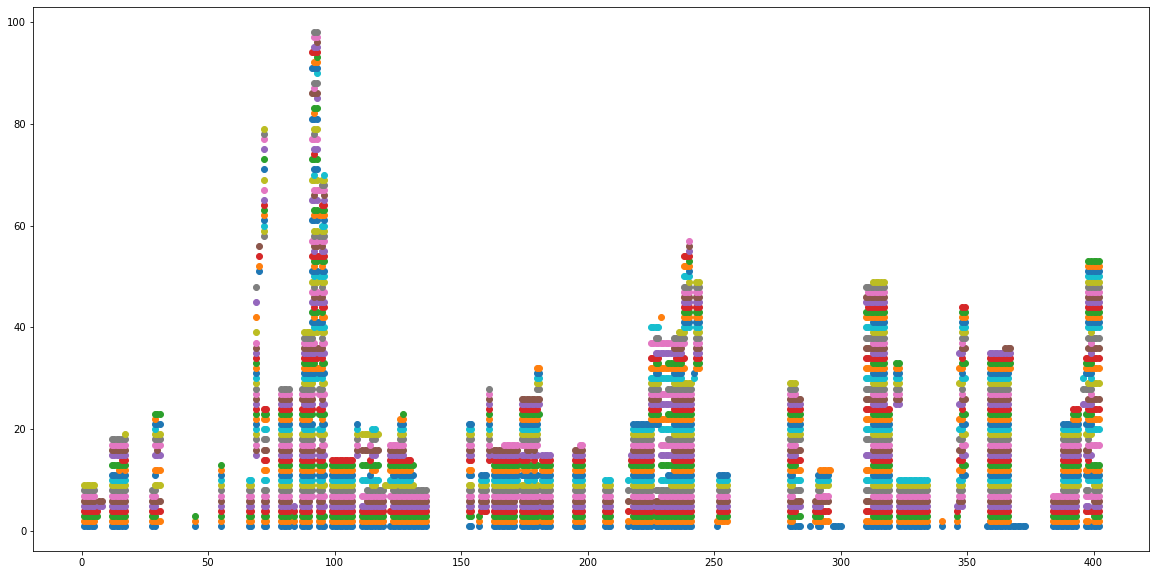

In [886]:
plt.subplots(figsize=(20,10))
x = range(len(long_read_collection[0]))

# for i in range(len(long_read_collection)):
for i in range(100):
    long_read_binary = [x * (i+1) for x in long_read_collection[i]]
    plt.scatter(x, long_read_binary)

In [888]:
person_reads.long_read.isna().sum()

0

In [ ]:
# Split reads evenly over space

# Create long read #1:
# Choose read1 in bin 1
# Choose read2 in bin 2 that does not overlap with read1
# Choose read3 in bin 3 that does not overlap with read2
# ...
# Choose read10 in bin 10 that does not overlap with read9

# Repeat until no more reads